In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [3]:
df = pd.read_csv('fandango_score_comparison.csv')

In [4]:
df.rename(columns={'Metacritic_user_norm_round':'Metacritic_user_norm'}, inplace=True)

In [5]:
rankings_lst = ['Fandango_Stars','RT_user_norm','RT_norm','IMDB_norm','Metacritic_user_norm',
 'Metacritic_norm']

In [6]:
def my_heatmap(df):
    import seaborn as sns
    fig, axes = plt.subplots()
    sns.heatmap(df, annot=True)
    plt.show()
    plt.close()

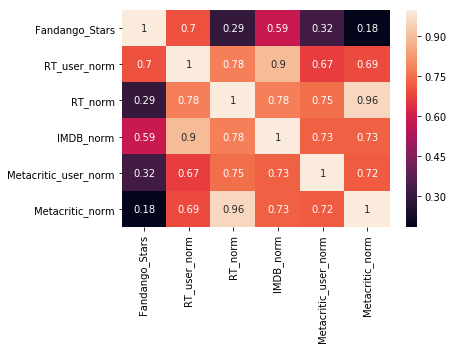

In [7]:
my_heatmap(df[rankings_lst].corr(method='pearson'))

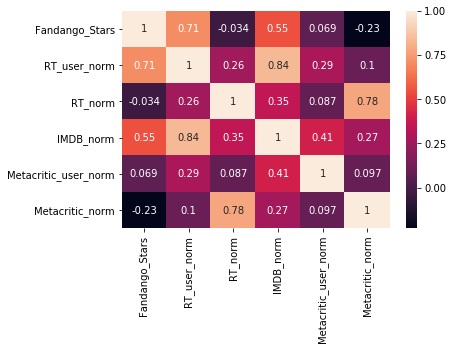

In [8]:
RT_lst = df['RT_norm'] >= 4.
my_heatmap(df[RT_lst][rankings_lst].corr(method='pearson'))

In [9]:
feature_cols = ['Fandango_Stars', 'RT_user_norm', 'RT_norm', 'Metacritic_user_norm', 'Metacritic_norm']
X = df.loc[:, feature_cols]

In [10]:
y = df['IMDB_norm']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=43)

In [12]:
dim = len(feature_cols)

In [13]:
dim += 1

In [14]:
X_train = X_train.assign( independent = pd.Series([1] * len(y_train), index=X_train.index))
X_test = X_test.assign( independent = pd.Series([1] * len(y_train), index=X_test.index))

In [15]:
P_train = X_train.as_matrix(columns=None)
P_test = X_test.as_matrix(columns=None)
q_train = np.array(y_train.values).reshape(-1,1)
q_test = np.array(y_test.values).reshape(-1,1)

In [16]:
P = tf.placeholder(tf.float32,[None,dim])
q = tf.placeholder(tf.float32,[None,1])
T = tf.Variable(tf.ones([dim,1]))

In [17]:
bias = tf.Variable(tf.constant(1.0, shape = [dim]))
q_ = tf.add(tf.matmul(P, T),bias)

In [18]:
cost = tf.reduce_mean(tf.square(q_ - q))
learning_rate = 0.0001
training_op = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

In [19]:
init_op = tf.global_variables_initializer()
cost_history = np.empty(shape=[1],dtype=float)

In [20]:
training_epochs = 50000
with tf.Session() as sess:
    sess.run(init_op)
    cost_history = np.empty(shape=[1], dtype=float)
    t_history = np.empty(shape=[dim, 1], dtype=float)
    for epoch in range(training_epochs):
        sess.run(training_op, feed_dict={P: P_train, q: q_train})
        cost_history = np.append(cost_history, sess.run(cost, feed_dict={P: P_train, q: q_train}))
        t_history = np.append(t_history, sess.run(T, feed_dict={P:P_train, q: q_train}), axis=1)
    q_pred = sess.run(q_, feed_dict={P: P_test})[:, 0]
    mse = tf.reduce_mean(tf.square(q_pred - q_test))
    mse_temp = mse.eval()
    sess.close()

In [21]:
print(mse_temp)
RMSE = math.sqrt(mse_temp)
print(RMSE)

0.4294541270894264
0.6553274960578309


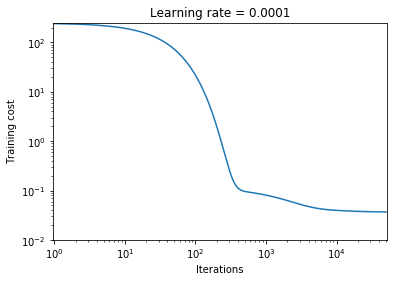

In [22]:
fig, axes = plt.subplots()
plt.plot(range(len(cost_history)), cost_history)
axes.set_xlim(xmin=0.95)
axes.set_ylim(ymin=1.e-2)
axes.set_xscale("log", nonposx='clip')
axes.set_yscale("log", nonposy='clip')
axes.set_ylabel('Training cost')
axes.set_xlabel('Iterations')
axes.set_title('Learning rate = ' + str(learning_rate))
plt.show()
plt.close()

In [23]:
predictedDF = X_test.copy(deep=True)
predictedDF.insert(loc=0, column='IMDB_norm_predicted', value=pd.Series(data=q_pred,
                                                                        index=predictedDF.index))
predictedDF.insert(loc=0, column='IMDB_norm_actual', value=q_test)
print('Predicted vs actual rating using LR with TensorFlow')
print(predictedDF[['IMDB_norm_actual', 'IMDB_norm_predicted']].head())
print(predictedDF[['IMDB_norm_actual', 'IMDB_norm_predicted']].tail())

Predicted vs actual rating using LR with TensorFlow
     IMDB_norm_actual  IMDB_norm_predicted
45               3.30             3.200483
50               3.35             3.427913
98               3.05             2.907741
119              3.60             3.788511
133              2.15             2.524110
     IMDB_norm_actual  IMDB_norm_predicted
140              4.30             4.028998
143              3.70             3.797575
42               4.10             3.977932
90               3.05             3.249516
40               3.45             3.526335


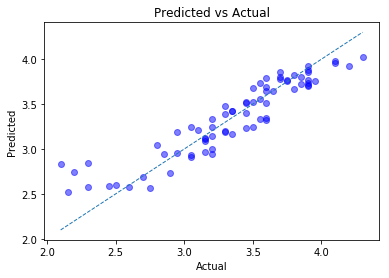

In [24]:
plt.scatter(q_test, q_pred, color='blue', alpha=0.5)
plt.plot([q_test.min(), q_test.max()], [q_test.min(), q_test.
max()], '--', lw=1)
plt.title('Predicted vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
plt.show()